<a href="https://colab.research.google.com/github/nicolas-chaulet/torch-points3d/blob/master/notebooks/PartSegmentationKPConv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Setup packages
!pip install torch==1.3.1 pyvista torchvision==0.4.2 pytorch-lightning
!pip install --upgrade jsonschema
!pip install torch-points3d
!apt-get install -qq xvfb libgl1-mesa-glx

In [6]:
!pip uninstall torch-points3d -y
!pip install git+git://github.com/nicolas-chaulet/torch-points3d@bug/transforms

Uninstalling torch-points3d-0.2.1:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/torch_points3d-0.2.1.dist-info/*
    /usr/local/lib/python3.6/dist-packages/torch_points3d/*
Proceed (y/n)? y
  Successfully uninstalled torch-points3d-0.2.1
  Cloning git://github.com/nicolas-chaulet/torch-points3d (to revision bug/transforms) to /tmp/pip-req-build-uepv7zgr
  Running command git clone -q git://github.com/nicolas-chaulet/torch-points3d /tmp/pip-req-build-uepv7zgr
  Running command git checkout -b bug/transforms --track origin/bug/transforms
  Switched to a new branch 'bug/transforms'
  Branch 'bug/transforms' set up to track remote branch 'bug/transforms' from 'origin'.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for torch-points3d: filename=torch_points3d-0.1.0-cp36-none-any.whl size=226032 sha256=74204bf9990d5cf88c8106cddd543494094abbae689c3c422620ad654d555267
  Stored in direct

In [2]:
# Needed for remote rendering 
import os
os.environ["DISPLAY"] = ":1.0"
os.environ["PYVISTA_OFF_SCREEN"]="true"
os.environ["PYVISTA_PLOT_THEME"]="true"
os.environ["PYVISTA_USE_PANEL"]="true"
os.environ["PYVISTA_AUTO_CLOSE"]="false"
os.system("Xvfb :1 -screen 0 1024x768x24 > /dev/null 2>&1 &")

0

In [0]:
import os
import sys
from omegaconf import OmegaConf
import pyvista as pv
import torch
import numpy as np

In [0]:
DIR = "" # Replace with your root directory, the data will go in DIR/data.

<p align="center">
  <img width="40%" src="https://raw.githubusercontent.com/nicolas-chaulet/torch-points3d/master/docs/logo.png" />
</p>

# Segmenting objects in part with KPConv
In this notebook we will solve the task of segmenting an object into its sub parts by using a [KPConv](https://arxiv.org/abs/1904.08889) deep neural network.
We will work on [ShapeNet](https://www.shapenet.org/) dataset which contains 48,600 3D models over 55 common categories with part annotations. We will show you how you can use Torch Points3D to setup a KPConv backbone with a multi head classifier and train it on ShapeNet. We will in particular cover the CPU pre processing of the data that allows a complex KPConv to perform well.

## The dataset
We use Torch Points3D version of ShapeNet that provides automatic download (be patient, it takes some time...) of the data, a tested metric tracker as well as methods for pre computing the spatial operations such as neighbour search and grid sampling on CPU.

Let's start with the data config (if you want more details about that part of Torch Points3D please refer to this notebook).

In [0]:
shapenet_yaml = """
class: shapenet.ShapeNetDataset
task: segmentation
dataroot: %s
normal: True                                  # Use normal vectors as features
category: Bag
first_subsampling: 0.02                       # Grid size of the input data
pre_transforms:                               # Offline transforms, done only once
    - transform: NormalizeScale           
    - transform: GridSampling
      params:
        size: ${first_subsampling}
train_transforms:                             # Data augmentation pipeline
    - transform: RandomNoise
      params:
        sigma: 0.01
        clip: 0.05
    - transform: RandomScaleAnisotropic
      params:
        scales: [0.9,1.1]
    - transform: AddOnes
    - transform: AddFeatsByKeys
      params:
        list_add_to_x: [True]
        feat_names: ["ones"]
        delete_feats: [True]
test_transforms:
    - transform: AddOnes
    - transform: AddFeatsByKeys
      params:
        list_add_to_x: [True]
        feat_names: ["ones"]
        delete_feats: [True]
""" % (os.path.join(DIR,"data"))

from omegaconf import OmegaConf
params = OmegaConf.create(shapenet_yaml)

In [6]:
from torch_points3d.datasets.segmentation import ShapeNetDataset
dataset = ShapeNetDataset(params)
dataset

Dataset: ShapeNetDataset 
pre_transform = Compose([
    NormalizeScale(),
    GridSampling(grid_size=0.02, quantize_coords=False, mode=mean),
])
test_transform = Compose([
    AddOnes(),
    AddFeatsByKeys(ones=True),
])
train_transform = Compose([
    RandomNoise(sigma=0.01, clip=0.05),
    RandomScaleAnisotropic([0.9, 1.1]),
    AddOnes(),
    AddFeatsByKeys(ones=True),
])
val_transform = None
inference_transform = Compose([
    NormalizeScale(),
    GridSampling(grid_size=0.02, quantize_coords=False, mode=mean),
    AddOnes(),
    AddFeatsByKeys(ones=True),
])
Size of train_dataset = 62
Size of test_dataset = 14
Size of val_dataset = 0
Batch size = None

In [1]:
#@title Plot samples with part annotations { run: "auto" }
objectid_1 = 1 #@param {type:"integer"}
objectid_2 = 2 #@param {type:"integer"}
objectid_3 = 3 #@param {type:"integer"}

samples = [objectid_1,objectid_2,objectid_3]
p = pv.Plotter(notebook=True,shape=(1, len(samples)),window_size=[1024,412])
for i in range(len(samples)):
    p.subplot(0, i)
    sample = dataset.train_dataset[samples[i]]
    point_cloud = pv.PolyData(sample.pos.numpy())
    point_cloud['y'] = sample.y.numpy()
    p.add_points(point_cloud,  show_scalar_bar=False, point_size=3)
    p.camera_position = [-1,5, -10]
p.show()

NameError: ignored

## Model for part segmentation
Let's start by creating a multihead segmentation module with one segmentation head per category. We provide that as part of Torch Points3D but let's reproduce it here for sake of completeness.

In [0]:
from torch_points3d.core.common_modules import MLP, UnaryConv

class MultiHeadClassifier(torch.nn.Module):
    """ Allows segregated segmentation in case the category of an object is known. 
    This is the case in ShapeNet for example.

    Parameters
    ----------
    in_features -
        size of the input channel
    cat_to_seg
        category to segment maps for example:
        {
            'Airplane': [0,1,2],
            'Table': [3,4]
        }

    """

    def __init__(self, in_features, cat_to_seg, dropout_proba=0.5, bn_momentum=0.1):
        super().__init__()
        self._cat_to_seg = {}
        self._num_categories = len(cat_to_seg)
        self._max_seg_count = 0
        self._max_seg = 0
        self._shifts = torch.zeros((self._num_categories,), dtype=torch.long)
        for i, seg in enumerate(cat_to_seg.values()):
            self._max_seg_count = max(self._max_seg_count, len(seg))
            self._max_seg = max(self._max_seg, max(seg))
            self._shifts[i] = min(seg)
            self._cat_to_seg[i] = seg

        self.channel_rasing = MLP(
            [in_features, self._num_categories * in_features], bn_momentum=bn_momentum, bias=False
        )
        if dropout_proba:
            self.channel_rasing.add_module("Dropout", torch.nn.Dropout(p=dropout_proba))

        self.classifier = UnaryConv((self._num_categories, in_features, self._max_seg_count))
        self._bias = torch.nn.Parameter(torch.zeros(self._max_seg_count,))

    def forward(self, features, category_labels, **kwargs):
        assert features.dim() == 2
        self._shifts = self._shifts.to(features.device)
        in_dim = features.shape[-1]
        features = self.channel_rasing(features)
        features = features.reshape((-1, self._num_categories, in_dim))
        features = features.transpose(0, 1)  # [num_categories, num_points, in_dim]
        features = self.classifier(features) + self._bias  # [num_categories, num_points, max_seg]
        ind = category_labels.unsqueeze(-1).repeat(1, 1, features.shape[-1]).long()

        logits = features.gather(0, ind).squeeze(0)
        softmax = torch.nn.functional.log_softmax(logits, dim=-1)

        output = torch.zeros(logits.shape[0], self._max_seg + 1).to(features.device)
        cats_in_batch = torch.unique(category_labels)
        for cat in cats_in_batch:
            cat_mask = category_labels == cat
            seg_indices = self._cat_to_seg[cat.item()]
            probs = softmax[cat_mask, : len(seg_indices)]
            output[cat_mask, seg_indices[0] : seg_indices[-1] + 1] = probs
        
        return output

The model we implement here follows the main architecture proposed in the [original paper](https://arxiv.org/abs/1904.08889):

<p align="center">
  <img width="70%" src="https://drive.google.com/uc?export=view&id=1CJppQ88T69whjYsJc016L3_E_rtcJ8n1" />
</p>

In [8]:
from torch_points3d.applications.kpconv import KPConv


class PartSegKPConv(torch.nn.Module):
    def __init__(self, cat_to_seg):
        super().__init__()
        self.unet = KPConv(
            architecture="unet", 
            input_nc=3, 
            num_layers=4, 
            in_grid_size=0.02
            )
        self.classifier = MultiHeadClassifier(self.unet.output_nc, cat_to_seg)
    
    @property
    def conv_type(self):
        """ This is needed by the dataset to infer which batch collate should be used"""
        return self.unet.conv_type
    
    def get_batch(self):
        return self.batch
    
    def get_output(self):
        """ This is needed by the tracker to get access to the ouputs of the network"""
        return self.output
    
    def get_labels(self):
        """ Needed by the tracker in order to access ground truth labels"""
        return self.labels
    
    def get_current_losses(self):
        """ Entry point for the tracker to grab the loss """
        return {"loss_seg": float(self.loss_seg)}

    def forward(self, data):
        self.labels = data.y
        self.batch = data.batch
        
        # Forward through unet and classifier
        data_features = self.unet(data)
        self.output = self.classifier(data_features.x, data.category)

         # Set loss for the backward pass
        self.loss_seg = torch.nn.functional.nll_loss(self.output, self.labels)
        return self.output

    def get_spatial_ops(self):
        return self.unet.get_spatial_ops()
        
    def backward(self):
         self.loss_seg.backward() 

    

ERROR:root:The testing module requires faiss. You can install the GPU version with the command 'conda install faiss-gpu -c pytorch' 
                        or the CPU version with 'conda install faiss-cpu -c pytorch'. Learn more at https://github.com/facebookresearch/faiss/blob/master/INSTALL.md


In [0]:
model = PartSegKPConv(dataset.class_to_segments)

## The data loaders and CPU pre computing features
KPConv is quite demanding on spatial operations such as grid sampling and radius search. On the network loaded here we have 10 KPConv layers on the encoder which means 10 radius search operations with varying number of neighbours. We observed a significant performance gain by moving those operations to the CPU where they can easily be optimised with suitable data structures such as kd-tree. We use [nonaflann](https://github.com/jlblancoc/nanoflann) in the back-end, a 3D optimised kd-tree implementation. Note that this is beneficiary only if you have access to multiple CPU threads.

You can decide to precompute those spatial operations by setting the `precompute_multi_scale` parameter to `True` when creating the data loaders. The dataset will mine the model to figure out which spatial operations are required and in which order.

In [0]:
NUM_WORKERS = 4
BATCH_SIZE = 6
dataset.create_dataloaders(
    model,
    batch_size=BATCH_SIZE, 
    num_workers=NUM_WORKERS, 
    shuffle=True, 
    precompute_multi_scale=False 
    )

In [45]:
sample = next(iter(dataset.train_dataloader))
sample.keys

['x', 'y', 'pos', 'multiscale', 'upsample', 'batch', 'category']

Our `sample` contains the pre computed spatial information in the `multiscale` (encoder side) and `upsample` (decoder) attrivutes. The decoder pre computing is quite simple and just involves some basic caching for the nearest neighbour interpolation operation. Let's take a look at the encoder side of things first. 

In [46]:
sample.multiscale

[Batch(batch=[10631], idx_neighboors=[10631, 25], pos=[10631, 3]),
 Batch(batch=[10631], idx_neighboors=[10631, 25], pos=[10631, 3]),
 Batch(batch=[4191], idx_neighboors=[4191, 25], pos=[4191, 3]),
 Batch(batch=[4191], idx_neighboors=[4191, 30], pos=[4191, 3]),
 Batch(batch=[893], idx_neighboors=[893, 30], pos=[893, 3]),
 Batch(batch=[893], idx_neighboors=[893, 38], pos=[893, 3]),
 Batch(batch=[212], idx_neighboors=[212, 38], pos=[212, 3]),
 Batch(batch=[212], idx_neighboors=[212, 38], pos=[212, 3]),
 Batch(batch=[66], idx_neighboors=[66, 38], pos=[66, 3]),
 Batch(batch=[66], idx_neighboors=[66, 38], pos=[66, 3])]

`sample.multiscale` contains 10 different versions of the input batch, each one of these versions contains the location of the points in `pos` as well as the neighbours of these points in the previous point cloud. We will first look at the points coming out of each downsampling layer (strided convolution), we have 5 of them.

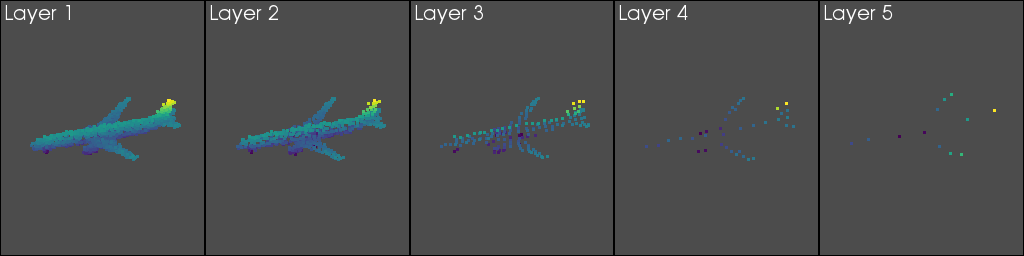

In [47]:
#@title Successive downsampling {run:"auto"}
sample_in_batch = 5 #@param {type:"integer"}
ms_data = sample.multiscale 
num_downsize = int(len(ms_data) / 2)
p = pv.Plotter(notebook=True,shape=(1, num_downsize),window_size=[1024,256])
for i in range(0,num_downsize):
    p.subplot(0, i)
    pos = ms_data[2*i].pos[ms_data[2*i].batch == sample_in_batch].numpy()
    point_cloud = pv.PolyData(pos)
    point_cloud['y'] = pos[:,1]
    p.add_points(point_cloud,  show_scalar_bar=False, point_size=3)
    p.add_text("Layer {}".format(i+1),font_size=10)
    p.camera_position = [-1,5, -10]
p.show()

Let's now take one point in a layer (query point) and show its neighbours in the previous layer (support point)

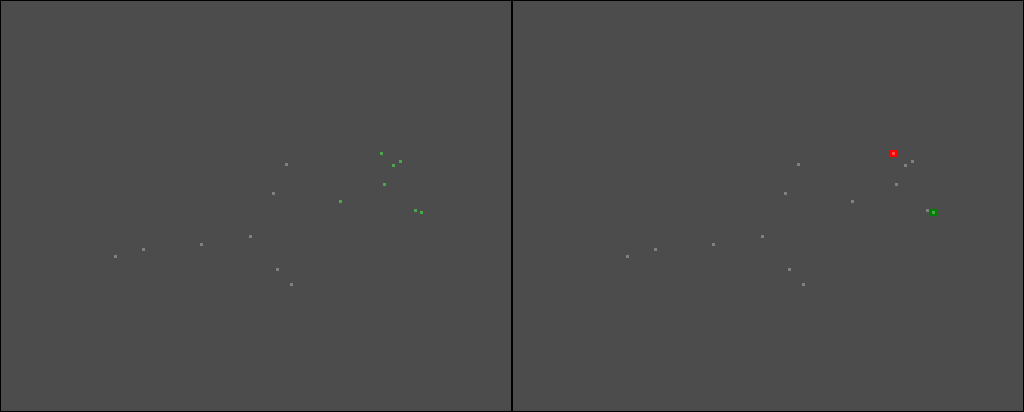

In [48]:
#@title Explore Neighborhood {run: "auto"}
selected_layer = 9 #@param {type:"integer"}
sample_in_batch = 1 #@param {type:"integer"}
point1_id = 10 #@param {type:"integer"}
point2_id =  1#@param {type:"integer"}

p = pv.Plotter(notebook=True,shape=(1, 2),window_size=[1024,412])

# Selected layer
p.subplot(0, 1)
ms_data = sample.multiscale[selected_layer]
pos = ms_data.pos[ms_data.batch == sample_in_batch].numpy()
nei = ms_data.idx_neighboors[ms_data.batch == sample_in_batch]
point_cloud = pv.PolyData(pos)
p.add_points(point_cloud,  show_scalar_bar=False, point_size=3,opacity=0.3)
p.add_points(pos[point1_id,:],  show_scalar_bar=False, point_size=7.0,color='red')
p.add_points(pos[point2_id,:],  show_scalar_bar=False, point_size=7.0,color='green')
p.camera_position = [-1,5, -10]

# Previous layer
p.subplot(0, 0)
ms_data = sample.multiscale[selected_layer-1]
pos = ms_data.pos[ms_data.batch == sample_in_batch].numpy()
point_cloud = pv.PolyData(pos)
p.add_points(point_cloud,  show_scalar_bar=False,point_size=3, opacity=0.3)
nei_pos = ms_data.pos[nei[point1_id]].numpy()
nei_pos = nei_pos[nei[point1_id] >= 0]
p.add_points(nei_pos,  show_scalar_bar=False, point_size=3.0,color='red')
nei_pos = ms_data.pos[nei[point2_id]].numpy()
nei_pos = nei_pos[nei[point2_id] >= 0]
p.add_points(nei_pos,  show_scalar_bar=False, point_size=3.0,color='green')
p.camera_position = [-1,5, -10]

p.show()

## Training loop

In [0]:
import pytorch_lightning as pl
class LightningModel(pl.LightningModule):
    def __init__(self, model, dataset):
        super().__init__()
        self._model = model
        self._dataset = dataset
        self._tracker = dataset.get_tracker(False,False)

    def forward(self, data):
        self._model(data)
        return self._model.get_output()

    def training_step(self, data, *args):
        self(data)
        # self._tracker.track(self._model)
        return {'loss': self._model.loss_seg}
    
    def training_epoch_end(self, outputs, *args):
        metrics = self._tracker.get_metrics()
        self._tracker.reset('val')
        return {
            'loss': torch.stack([x['loss'] for x in outputs]).mean(),
             'log':metrics
        }

    def validation_step(self, data, *args):
        self(data)
        self._tracker.track(self._model)
        return {'val_loss': self._model.loss_seg,'log': self._tracker.get_metrics()}

    def validation_epoch_end(self, outputs):
        metrics = self._tracker.get_metrics()
        self._tracker.reset('train')
        output = {
            'val_loss': torch.stack([x['val_loss'] for x in outputs]).mean(),
             'log':metrics
        }
        print(output)
        return output

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

    def train_dataloader(self):
        return self._dataset.train_dataloader

    def val_dataloader(self):
        return self._dataset.test_dataloaders[0]

In [0]:
l_model = LightningModel(model,dataset)

In [0]:
trainer = pl.Trainer(row_log_interval=1)
trainer.fit(l_model)

{'val_loss': tensor(0.6741), 'log': {'train_loss_seg': 0.6741112073262533, 'train_Cmiou': 44.80436477971074, 'train_Imiou': 44.80436477971074}}


{'val_loss': tensor(0.5963), 'log': {'train_loss_seg': 0.5963320732116699, 'train_Cmiou': 44.80436477971074, 'train_Imiou': 44.80436477971074}}


{'val_loss': tensor(0.4236), 'log': {'val_loss_seg': 0.4236452082792918, 'val_Cmiou': 44.80436477971074, 'val_Imiou': 44.80436477971074}}


{'val_loss': tensor(0.3560), 'log': {'val_loss_seg': 0.3559507429599762, 'val_Cmiou': 44.80436477971074, 'val_Imiou': 44.80436477971074}}


{'val_loss': tensor(0.3478), 'log': {'val_loss_seg': 0.3478154242038727, 'val_Cmiou': 44.803049336406346, 'val_Imiou': 44.803049336406346}}


{'val_loss': tensor(0.3619), 'log': {'val_loss_seg': 0.3619270821412404, 'val_Cmiou': 44.80436477971074, 'val_Imiou': 44.80436477971074}}


{'val_loss': tensor(0.3700), 'log': {'val_loss_seg': 0.3699589769045512, 'val_Cmiou': 48.628034475867786, 'val_Imiou': 48.628034475867786}}
